In [3]:
import jupyter_utils as j

j.reload(j)

In [12]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split as split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, average_precision_score

from matplotlib import pyplot as plt

import matplotlib

matplotlib.style.use('ggplot')

j.apply_options(pd)
j.reload(j)

%matplotlib inline

In [13]:
data = pd.read_csv('sparkify_data_final.csv')
data = data.drop(['userId'] ,axis = 1)

pd.set_option('use_inf_as_na', True)

# data['days_time_away'] = (data.session_avg_time_away / data.n_days) / data.avg_session_duration

# data['days_time_away'] = (data.session_avg_time_away / data.avg_session_duration) / data.n_days 
 
data = data.dropna()

data = data.drop(list(filter(lambda c: len(c) == 2, data.columns)), axis = 1)
 
data = data.drop(['state', 'avg_daily_actions'], axis = 1)

In [14]:
data.head(10)

,session_avg_time_away,n_songs,n_home,n_downgrades,session_avg_playback,n_upgrades,session_avg_songs,canceled,session_avg_settings,session_avg_help,n_errors,session_avg_home,n_days,n_friends,session_avg_errors,session_avg_likes,n_settings,male,n_added_to_playlist,n_help,n_ads,time_window,n_likes,paid,session_avg_ads,n_actions,avg_session_duration,n_sess,n_dislikes,session_avg_friends,session_avg_dislikes,session_avg_added_playlist,session_avg_actions
0,66.022500,96,3,0,1.024795,0,13.689840,1,0.000000,0.000000,0,0.427807,2,3,0.000000,0.570410,0,0,1,0,22,73.035000,4,0,3.137255,137,3.507733,2,3,0.427807,0.427807,0.142602,19.536542
1,166.991528,310,23,0,0.997185,1,14.141261,1,0.091234,0.045617,0,1.049190,6,2,0.000000,0.684255,2,1,6,1,11,689.887778,15,0,0.501787,395,5.758219,5,5,0.091234,0.228085,0.273702,18.018703
2,47.248056,112,7,0,0.972627,1,13.850435,1,0.123665,0.247329,0,0.865652,5,2,0.000000,0.989317,1,0,3,2,9,197.078611,8,1,1.112981,152,2.761294,5,0,0.247329,0.000000,0.370994,18.797018
3,522.412639,62,2,0,1.033783,0,14.591096,0,0.706021,0.470681,0,0.470681,3,3,0.000000,0.706021,3,1,2,2,6,1049.074444,3,0,1.412042,84,2.938208,3,1,0.706021,0.235340,0.470681,19.768582
4,53.600208,1826,70,0,1.067369,0,14.460789,1,0.118791,0.079194,0,0.554357,20,26,0.000000,0.807777,15,0,45,10,1,983.875833,102,1,0.007919,2156,14.717388,17,15,0.205904,0.118791,0.356372,17.074185
5,87.977986,266,17,0,1.013841,0,14.530005,1,0.109248,0.000000,2,0.928609,6,3,0.109248,0.873985,2,1,8,0,1,370.218889,16,1,0.054624,328,7.115083,5,1,0.163872,0.054624,0.436993,17.916698
6,95.152480,462,36,0,1.013385,0,14.531475,0,0.157267,0.094360,0,1.132323,15,16,0.000000,0.377441,5,1,6,3,35,1363.927778,12,0,1.100869,600,3.818930,15,4,0.503255,0.125814,0.188720,18.872046
7,60.725833,122,6,0,1.054349,0,15.375998,1,0.126033,0.000000,0,0.756197,6,2,0.000000,0.630164,1,1,4,0,9,372.289444,5,0,1.134295,155,1.925077,7,3,0.252066,0.378098,0.504131,19.535079
8,201.516190,112,6,0,1.069652,0,15.384615,0,0.412088,0.000000,0,0.824176,8,6,0.000000,0.824176,3,1,0,0,13,1417.893333,6,0,1.785714,149,1.202651,8,0,0.824176,0.000000,0.000000,20.467033
9,269.713125,1048,43,0,1.005280,0,14.385395,0,0.041180,0.150992,1,0.590240,9,21,0.013727,0.686326,3,0,25,11,0,1151.704167,50,1,0.000000,1244,21.700945,5,10,0.288257,0.137265,0.343163,17.075793


In [33]:
def plot_roc_curve(y_test, y_predictions, model, action = 'Training'):
    
    fp, tp, _ = roc_curve(y_test, y_predictions)
    auc = roc_auc_score(y_test, y_predictions)
    
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fp, tp, color = 'darkorange', label = model.__class__.__name__)
    
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(f'{action} - ROC curve (area = {np.around(auc, 4)})')
    plt.legend(loc = 'best')
    plt.show()
    
def plot_metrics(y_test, y_predictions):
    
    auc = roc_auc_score(y_test, y_predictions)
    cm = confusion_matrix(y_test, y_predictions, labels = [1, 0])
    
    tn = cm[0, 0]
    tp = cm[1, 1]
    fn = cm[1, 0]
    fp = cm[0, 1]
    
    total = np.sum(cm) # tn + tp + fn + fp
    accuracy = (tp + tn) / total
    precision = (tp) / (tp + fp)
    recall = (tp) / (tp + fn) 
    
    print(cm)
    print('')
    print('accuracy.................%7.4f' % accuracy)
    print('precision................%7.4f' % precision)
    print('recall...................%7.4f' % recall)
    print('auc......................%7.4f' % auc)
    print('F1 macro.................%7.4f' % f1_score(y_test, y_predictions, average = 'macro'))
    print('F1 micro.................%7.4f' % f1_score(y_test, y_predictions, average = 'micro'))
    print('F1 weighted..............%7.4f' % f1_score(y_test, y_predictions, average = 'weighted'))
    # f1 = (2 * tp ) / (2 * tp + fp + fn) - f1_score with average 'binary'
    print('F1 binary................%7.4f' % f1_score(y_test, y_predictions, average = 'binary', labels = [1, 0]))
    
def train_model(df, label, classifier): 

    x = df.drop([label], axis = 1)
    y = df[label]

    X_train, X_test, y_train, y_test = split(x, y, test_size = .2, random_state = 42)
    
    model = classifier.fit(X_train, y_train)
    
    # Train
    # y_predicted = model.predict(X_train)
    # plot_roc_curve(y_train, y_predicted, model)
    # plot_metrics(y_train, y_predicted)
    
    # Testing
    y_predicted = model.predict(X_test)
    plot_roc_curve(y_test, y_predicted, model, 'Testing')
    plot_metrics(y_test, y_predicted)
    
    return model

def train_random_forest(df, label):
    
    cl = RandomForestClassifier(n_estimators = 100, n_jobs = -1, class_weight = 'balanced', criterion = 'gini', random_state = 42)
    return train_model(df, label, cl)

def train_logistic_regression(df, label):
    
    lr = LogisticRegression(solver = 'lbfgs', n_jobs = -1, class_weight = 'balanced', random_state = 42)
    return train_model(df, label, lr)

def train_gradient_boosting(df, label): 
    gbl = GradientBoostingClassifier(n_estimators = 200, max_depth = 6, learning_rate = 0.1, random_state = 42)
    return train_model(df, label, gbl)


from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import fbeta_score, recall_score

f1 = make_scorer(f1_score, average = 'binary') # 0.000000001

# f1 = make_scorer(recall_score , average = 'binary',  labels = [1, 0])


from sklearn.model_selection import ShuffleSplit

def train_gs_gradient_boosting(df, label):
    
    kfold = StratifiedKFold(n_splits=3, shuffle=False, random_state=42)
    
    grid_values = {
        # 'subsample': [0.1, 0.5, 0.9, 0.95, 0.99],
        # 'min_samples_split' : [.1, .2, .3, .5, .8, 1.0],
        'n_estimators': [100, 200, 300, 400],
        # 'learning_rate': [0.25, .1, 0.05, 0.02, 0.01], #, 0.015, 0.001],
        # 'max_depth': [4, 6, 8, 10],
        # 'max_features': [7, 14, 25, 30, 32],
        'min_samples_leaf': [1, 20, 50, 100, 150]
    }

    gb = GradientBoostingClassifier()
    # gb_gs = GridSearchCV(gb, param_grid = grid_values, return_train_score = True, verbose = 3, n_jobs = -1, cv = kfold, iid = False, scoring = f1)
    
    # Test
    x = df.drop([label], axis = 1)
    y = df[label]
    
    X_train, X_test, y_train, y_test = split(x, y, test_size = .3, random_state = 42)
    

    cv = ShuffleSplit(len(_x), test_size=0.3, random_state=42)
    
    # cv = StratifiedKFold(n_splits=3, shuffle=False, random_state=42).split(X_train, y_train)
    
    gb_gs = GridSearchCV(gb, param_grid = grid_values, return_train_score = True, verbose = 3, n_jobs = -1, cv = None, iid = False, scoring = 'roc_auc')
     
    model = gb_gs.fit(X_train, y_train)
 
    y_predicted = model.predict(X_test)
    plot_roc_curve(y_test, y_predicted, model, 'Testing')
    plot_metrics(y_test, y_predicted)
    
 
    return model

    # return train_model(df, label, gb_gs)

def train_gs_logistic_regression(df, label):
    
    grid_values = {
        'solver' : ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],  
        # 'penalty': [ 'l2' ], 
        # 'C': [.1, .4, 1, 2, 4, 6, 8, 10, 12, 20], 
        'max_iter': [50, 100, 200, 300, 500, 1000, 2000]
    }

    lr = LogisticRegression(n_jobs = -1, class_weight = 'balanced', random_state = 42)
    lg_gs = GridSearchCV(lr, param_grid = grid_values, return_train_score = True, verbose = 3, n_jobs = -1, cv = 10, scoring = 'roc_auc', iid = False)
    
    return train_model(df, label, lg_gs)
    
    
    
def train_gs_random_forest(df, label):
    
    rf = RandomForestClassifier(n_jobs = -1, class_weight = 'balanced', criterion = 'gini', random_state = 42)
    
    grid_values = {
        'bootstrap': [True, False],
        'oob_score': [True, False],
        'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 
        'max_features': ['auto', 'sqrt', 'log2'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
    }
    
    rf_gs = GridSearchCV(rf, param_grid = grid_values, return_train_score = True, verbose = 3, n_jobs = -1, cv = 3, scoring = f1, iid = False)
    
    return train_model(df, label, rf_gs)

In [546]:
from sklearn.model_selection import ShuffleSplit

ShuffleSplit(len(_x), test_size=0.3, random_state=0)

ShuffleSplit(n_splits=448, random_state=0, test_size=0.3, train_size=None)

In [15]:
from sklearn.preprocessing import Normalizer, RobustScaler, StandardScaler

# Filter average or absolute columns
features_to_normalize = list(filter(lambda column_name: '_' in column_name, data.columns))

_x = data.copy()
_x[features_to_normalize] = Normalizer().fit_transform(_x[features_to_normalize]) 

_x.head(10)

,session_avg_time_away,n_songs,n_home,n_downgrades,session_avg_playback,n_upgrades,session_avg_songs,canceled,session_avg_settings,session_avg_help,n_errors,session_avg_home,n_days,n_friends,session_avg_errors,session_avg_likes,n_settings,male,n_added_to_playlist,n_help,n_ads,time_window,n_likes,paid,session_avg_ads,n_actions,avg_session_duration,n_sess,n_dislikes,session_avg_friends,session_avg_dislikes,session_avg_added_playlist,session_avg_actions
0,0.335147,0.487321,0.015229,0.0,0.005202,0.000000,0.069493,1,0.000000,0.000000,0.000000,0.002172,0.010153,0.015229,0.000000,0.002896,0.000000,0,0.005076,0.000000,0.111678,0.370744,0.020305,0,0.015926,0.695447,0.017806,0.010153,0.015229,0.002172,0.002172,0.000724,0.099172
1,0.191865,0.356175,0.026426,0.0,0.001146,0.001149,0.016248,1,0.000105,0.000052,0.000000,0.001205,0.006894,0.002298,0.000000,0.000786,0.002298,1,0.006894,0.001149,0.012638,0.792648,0.017234,0,0.000577,0.453836,0.006616,0.005745,0.005745,0.000105,0.000262,0.000314,0.020703
2,0.169676,0.402211,0.025138,0.0,0.003493,0.003591,0.049739,1,0.000444,0.000888,0.000000,0.003109,0.017956,0.007182,0.000000,0.003553,0.003591,0,0.010774,0.007182,0.032321,0.707743,0.028729,1,0.003997,0.545858,0.009916,0.017956,0.000000,0.000888,0.000000,0.001332,0.067503
3,0.443890,0.052681,0.001699,0.0,0.000878,0.000000,0.012398,0,0.000600,0.000400,0.000000,0.000400,0.002549,0.002549,0.000000,0.000600,0.002549,1,0.001699,0.001699,0.005098,0.891391,0.002549,0,0.001200,0.071374,0.002497,0.002549,0.000850,0.000600,0.000200,0.000400,0.016797
4,0.017893,0.609566,0.023368,0.0,0.000356,0.000000,0.004827,1,0.000040,0.000026,0.000000,0.000185,0.006677,0.008679,0.000000,0.000270,0.005007,0,0.015022,0.003338,0.000334,0.328443,0.034050,1,0.000003,0.719729,0.004913,0.005675,0.005007,0.000069,0.000040,0.000119,0.005700
5,0.154462,0.467014,0.029847,0.0,0.001780,0.000000,0.025510,1,0.000192,0.000000,0.003511,0.001630,0.010534,0.005267,0.000192,0.001534,0.003511,1,0.014046,0.000000,0.001756,0.649990,0.028091,1,0.000096,0.575867,0.012492,0.008778,0.001756,0.000288,0.000096,0.000767,0.031456
6,0.060830,0.295352,0.023014,0.0,0.000648,0.000000,0.009290,0,0.000101,0.000060,0.000000,0.000724,0.009589,0.010229,0.000000,0.000241,0.003196,1,0.003836,0.001918,0.022375,0.871944,0.007671,0,0.000704,0.383573,0.002441,0.009589,0.002557,0.000322,0.000080,0.000121,0.012065
7,0.142313,0.285911,0.014061,0.0,0.002471,0.000000,0.036034,1,0.000295,0.000000,0.000000,0.001772,0.014061,0.004687,0.000000,0.001477,0.002344,1,0.009374,0.000000,0.021092,0.872471,0.011718,0,0.002658,0.363247,0.004511,0.016405,0.007031,0.000591,0.000886,0.001181,0.045781
8,0.139497,0.077530,0.004153,0.0,0.000740,0.000000,0.010650,0,0.000285,0.000000,0.000000,0.000571,0.005538,0.004153,0.000000,0.000571,0.002077,1,0.000000,0.000000,0.008999,0.981517,0.004153,0,0.001236,0.103143,0.000833,0.005538,0.000000,0.000571,0.000000,0.000000,0.014168
9,0.133993,0.520644,0.021362,0.0,0.000499,0.000000,0.007147,0,0.000020,0.000075,0.000497,0.000293,0.004471,0.010433,0.000007,0.000341,0.001490,0,0.012420,0.005465,0.000000,0.572164,0.024840,1,0.000000,0.618016,0.010781,0.002484,0.004968,0.000143,0.000068,0.000170,0.008483


Fitting 3 folds for each of 4356 candidates, totalling 13068 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1536 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 2016 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 2560 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 3840 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 4576 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done 5376 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-1)]: Done 6240 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 7168 tasks      | elapsed: 27.7min
[Parallel(n_jobs=-1)]: Done 8160 tasks      |

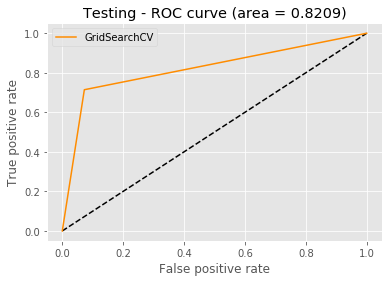

[[15  6]
 [ 5 64]]

accuracy................. 0.8778
precision................ 0.9143
recall................... 0.9275
auc...................... 0.8209
F1 macro................. 0.8263
F1 micro................. 0.8778
F1 weighted.............. 0.8767
F1 binary................ 0.7317


RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=4,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=400, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [34]:
model = train_gs_random_forest(_x, 'canceled')

model.best_estimator_

/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  29 out of  60 | elapsed:    0.6s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  50 out of  60 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.0s finished


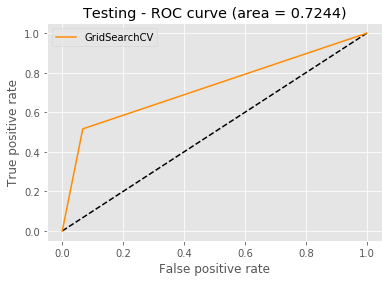

[[16 15]
 [ 7 97]]

accuracy................. 0.8370
precision................ 0.8661
recall................... 0.9327
auc...................... 0.7244
F1 macro................. 0.7454
F1 micro................. 0.8370
F1 weighted.............. 0.8280
F1 binary................ 0.5926


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [556]:
model = train_gs_gradient_boosting(_x, 'canceled')

model.best_estimator_

Fitting 3 folds for each of 50400 candidates, totalling 151200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 1536 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 2016 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 2560 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 3840 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 4576 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done 5376 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 6240 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 7168 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 8160 tasks      |

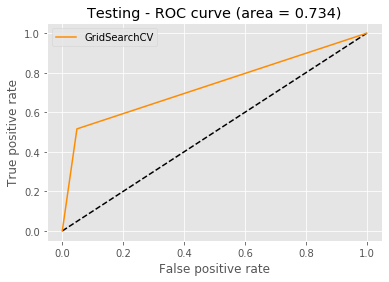

[[16 15]
 [ 5 99]]

accuracy................. 0.8519
precision................ 0.8684
recall................... 0.9519
auc...................... 0.7340
F1 macro................. 0.7618
F1 micro................. 0.8519
F1 weighted.............. 0.8410
F1 binary................ 0.6154


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.015, loss='deviance', max_depth=10,
                           max_features=14, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=20, min_samples_split=0.3,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=0.99, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [424]:
model = train_gs_gradient_boosting(_x, 'canceled')

model.best_estimator_

In [265]:
dir(model)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_is_fitted',
 '_estimator_type',
 '_format_results',
 '_get_param_names',
 '_get_tags',
 '_required_parameters',
 '_run_search',
 'best_estimator_',
 'best_index_',
 'best_params_',
 'best_score_',
 'classes_',
 'cv',
 'cv_results_',
 'decision_function',
 'error_score',
 'estimator',
 'fit',
 'get_params',
 'iid',
 'inverse_transform',
 'multimetric_',
 'n_jobs',
 'n_splits_',
 'param_grid',
 'pre_dispatch',
 'predict',
 'predict_log_proba',
 'predict_proba',
 'refit',
 'refit_time_',
 'return_train_score',
 'score',
 'scorer_',
 'scoring',
 '

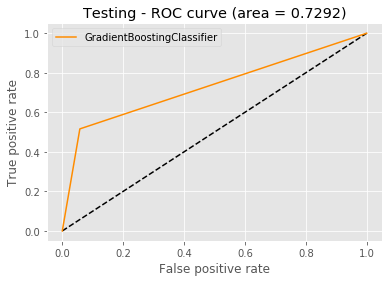

[[16 15]
 [ 6 98]]

accuracy................. 0.8444
precision................ 0.8673
recall................... 0.9423
auc...................... 0.7292
F1 macro................. 0.7535
F1 micro................. 0.8444
F1 weighted.............. 0.8345
F1 binary................ 0.6038


In [428]:
model = train_gradient_boosting(_x, 'canceled')

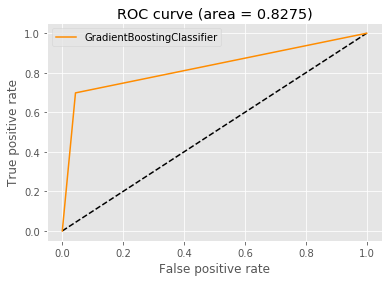

[[1060  458]
 [ 224 4942]]

accuracy................. 0.8980
precision................ 0.9152
recall................... 0.9566
auc...................... 0.8275
F1 macro................. 0.8460
F1 micro................. 0.8980
F1 weighted.............. 0.8948
F1 binary................ 0.7566


In [17]:
model = train_gradient_boosting(_x, 'canceled')

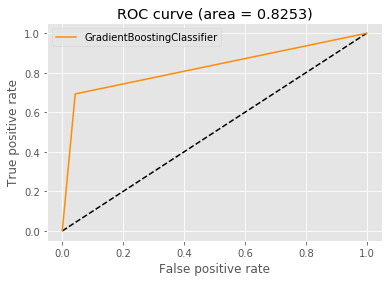

[[1052  466]
 [ 219 4947]]

accuracy................. 0.8975
precision................ 0.9139
recall................... 0.9576
auc...................... 0.8253
F1 macro................. 0.8448
F1 micro................. 0.8975
F1 weighted.............. 0.8942
F1 binary................ 0.7544


In [36]:
model = train_gradient_boosting(_x, 'canceled')

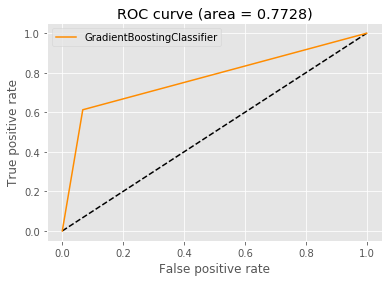

[[19 12]
 [ 7 97]]

accuracy................. 0.8593
precision................ 0.8899
recall................... 0.9327
auc...................... 0.7728
F1 macro................. 0.7887
F1 micro................. 0.8593
F1 weighted.............. 0.8547
F1 binary................ 0.6667


In [43]:
model = train_gradient_boosting(_x, 'canceled')

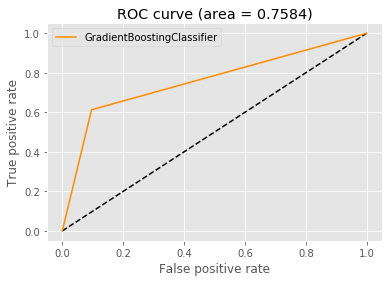

[[19 12]
 [10 94]]

accuracy................. 0.8370
precision................ 0.8868
recall................... 0.9038
auc...................... 0.7584
F1 macro................. 0.7643
F1 micro................. 0.8370
F1 weighted.............. 0.8351
F1 binary................ 0.6333


In [13]:
model = train_gradient_boosting(_x, 'canceled')

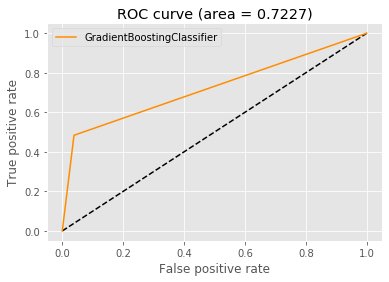

[[ 15  16]
 [  4 100]]

accuracy................. 0.8519
precision................ 0.8621
recall................... 0.9615
auc...................... 0.7227
F1 macro................. 0.7545
F1 micro................. 0.8519
F1 weighted.............. 0.8381
F1 binary................ 0.6000


In [107]:
model = train_gradient_boosting(_x, 'canc')

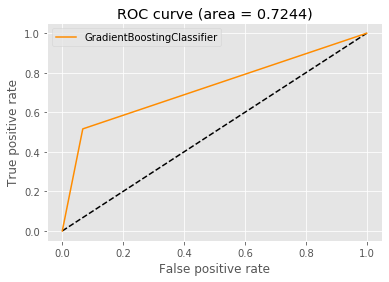

[[16 15]
 [ 7 97]]

accuracy................. 0.8370
precision................ 0.8661
recall................... 0.9327
auc...................... 0.7244
F1 macro................. 0.7454
F1 micro................. 0.8370
F1 weighted.............. 0.8280
F1 binary................ 0.5926


In [101]:
model = train_gradient_boosting(_x, 'canc')

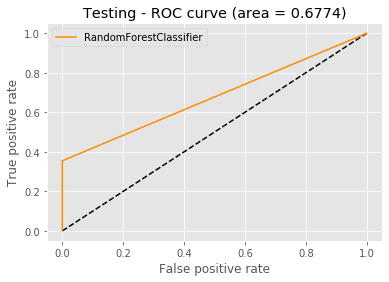

[[ 11  20]
 [  0 104]]

accuracy................. 0.8519
precision................ 0.8387
recall................... 1.0000
auc...................... 0.6774
F1 macro................. 0.7180
F1 micro................. 0.8519
F1 weighted.............. 0.8231
F1 binary................ 0.5238


In [426]:
model = train_random_forest(_x, 'canceled')

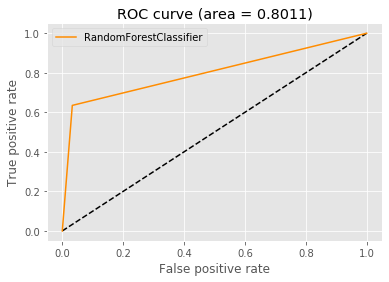

[[ 964  554]
 [ 170 4996]]

accuracy................. 0.8917
precision................ 0.9002
recall................... 0.9671
auc...................... 0.8011
F1 macro................. 0.8297
F1 micro................. 0.8917
F1 weighted.............. 0.8858
F1 binary................ 0.7270


In [13]:
model = train_random_forest(_x, 'canceled')

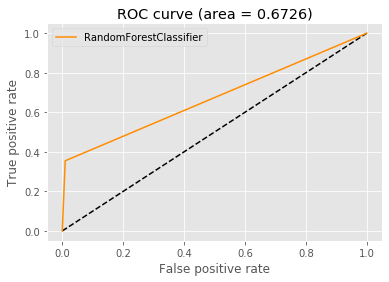

[[ 11  20]
 [  1 103]]

accuracy................. 0.8444
precision................ 0.8374
recall................... 0.9904
auc...................... 0.6726
F1 macro................. 0.7096
F1 micro................. 0.8444
F1 weighted.............. 0.8166
F1 binary................ 0.5116


In [44]:
model = train_random_forest(_x, 'canceled')

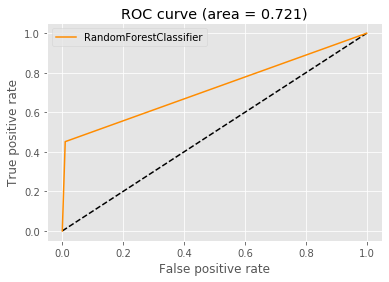

[[ 14  17]
 [  1 103]]

accuracy................. 0.8667
precision................ 0.8583
recall................... 0.9904
auc...................... 0.7210
F1 macro................. 0.7642
F1 micro................. 0.8667
F1 weighted.............. 0.8482
F1 binary................ 0.6087


In [14]:
model = train_random_forest(_x, 'canceled')

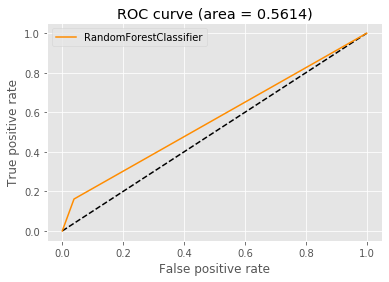

[[  5  26]
 [  4 100]]

accuracy................. 0.7778
precision................ 0.7937
recall................... 0.9615
auc...................... 0.5614
F1 macro................. 0.5598
F1 micro................. 0.7778
F1 weighted.............. 0.7273
F1 binary................ 0.2500


In [102]:
model = train_random_forest(_x, 'canc')

In [ ]:
importances = pd.Series(model.feature_importances_, index = average_columns).to_frame().reset_index()
importances.columns = ['feature', 'importance']
importances.sort_values(by = 'importance', ascending = False)

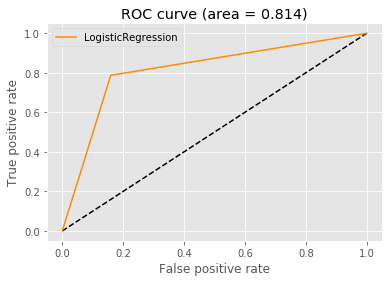

[[1195  323]
 [ 823 4343]]

accuracy................. 0.8285
precision................ 0.9308
recall................... 0.8407
auc...................... 0.8140
F1 macro................. 0.7797
F1 micro................. 0.8285
F1 weighted.............. 0.8363
F1 binary................ 0.6759


In [9]:
model = train_logistic_regression(_x, 'canceled')

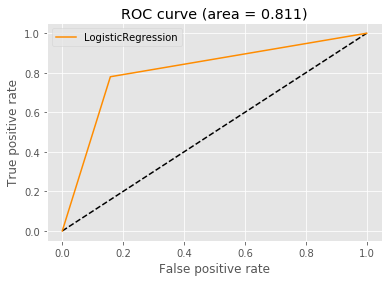

[[1184  334]
 [ 816 4350]]

accuracy................. 0.8279
precision................ 0.9287
recall................... 0.8420
auc...................... 0.8110
F1 macro................. 0.7782
F1 micro................. 0.8279
F1 weighted.............. 0.8355
F1 binary................ 0.6731


In [14]:
model = train_logistic_regression(_x, 'canceled')

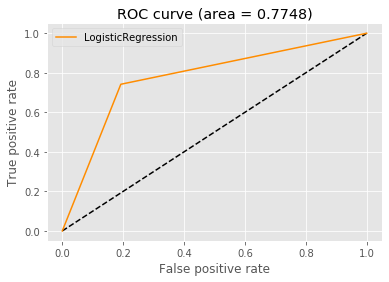

[[23  8]
 [20 84]]

accuracy................. 0.7926
precision................ 0.9130
recall................... 0.8077
auc...................... 0.7748
F1 macro................. 0.7394
F1 micro................. 0.7926
F1 weighted.............. 0.8031
F1 binary................ 0.6216


In [45]:
model = train_logistic_regression(_x, 'canceled')

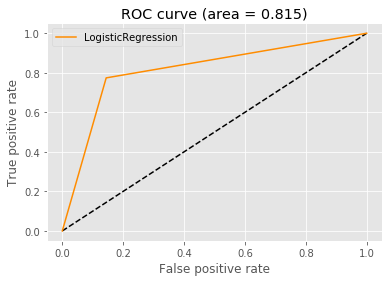

[[24  7]
 [15 89]]

accuracy................. 0.8370
precision................ 0.9271
recall................... 0.8558
auc...................... 0.8150
F1 macro................. 0.7879
F1 micro................. 0.8370
F1 weighted.............. 0.8431
F1 binary................ 0.6857


In [16]:
model = train_logistic_regression(_x, 'canceled')

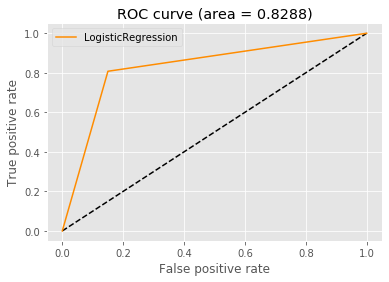

[[ 63  15]
 [ 42 238]]

accuracy................. 0.8408
precision................ 0.9407
recall................... 0.8500
auc...................... 0.8288
F1 macro................. 0.7908
F1 micro................. 0.8408
F1 weighted.............. 0.8485
F1 binary................ 0.6885


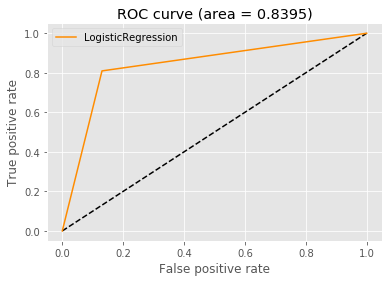

[[17  4]
 [ 9 60]]

accuracy................. 0.8556
precision................ 0.9375
recall................... 0.8696
auc...................... 0.8395
F1 macro................. 0.8128
F1 micro................. 0.8556
F1 weighted.............. 0.8605
F1 binary................ 0.7234


In [174]:
model = train_logistic_regression(_x, 'canceled')

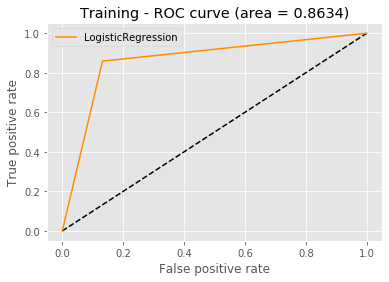

[[ 67  11]
 [ 37 243]]

accuracy................. 0.8659
precision................ 0.9567
recall................... 0.8679
auc...................... 0.8634
F1 macro................. 0.8232
F1 micro................. 0.8659
F1 weighted.............. 0.8722
F1 binary................ 0.7363


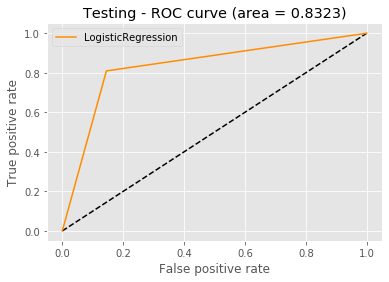

[[17  4]
 [10 59]]

accuracy................. 0.8444
precision................ 0.9365
recall................... 0.8551
auc...................... 0.8323
F1 macro................. 0.8011
F1 micro................. 0.8444
F1 weighted.............. 0.8506
F1 binary................ 0.7083


In [192]:
model = train_logistic_regression(_x, 'canceled')

/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


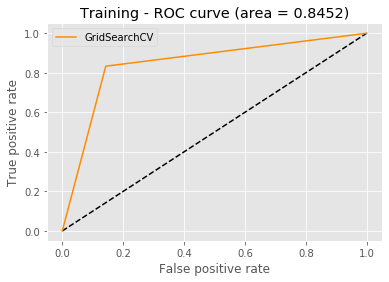

[[ 65  13]
 [ 40 240]]

accuracy................. 0.8520
precision................ 0.9486
recall................... 0.8571
auc...................... 0.8452
F1 macro................. 0.8055
F1 micro................. 0.8520
F1 weighted.............. 0.8591
F1 binary................ 0.7104


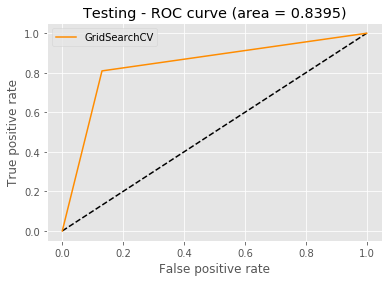

[[17  4]
 [ 9 60]]

accuracy................. 0.8556
precision................ 0.9375
recall................... 0.8696
auc...................... 0.8395
F1 macro................. 0.8128
F1 micro................. 0.8556
F1 weighted.............. 0.8605
F1 binary................ 0.7234


In [224]:
from sklearn.model_selection import GridSearchCV

model = train_gs_logistic_regression(_x, 'canceled')

In [408]:
model.best_params_

{'learning_rate': 0.25,
 'max_depth': 6,
 'max_features': 'sqrt',
 'min_samples_leaf': 100,
 'min_samples_split': 0.1,
 'n_estimators': 100,
 'subsample': 0.99}

Fitting 10 folds for each of 350 candidates, totalling 3500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 235 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 398 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 622 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 910 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 1262 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 1678 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done 2158 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2702 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3310 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 3500 out of 3500 | elapsed:  2.3min finished
/home/bruno/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


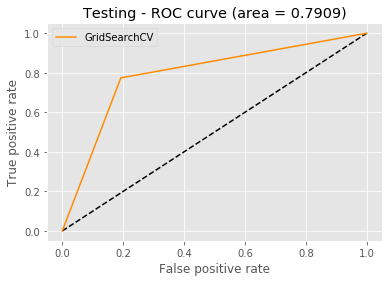

[[24  7]
 [20 84]]

accuracy................. 0.8000
precision................ 0.9231
recall................... 0.8077
auc...................... 0.7909
F1 macro................. 0.7508
F1 micro................. 0.8000
F1 weighted.............. 0.8107
F1 binary................ 0.6400


In [379]:
from sklearn.model_selection import GridSearchCV

model = train_gs_logistic_regression(_x, 'canceled')

In [320]:
dir(model)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_is_fitted',
 '_estimator_type',
 '_format_results',
 '_get_param_names',
 '_get_tags',
 '_required_parameters',
 '_run_search',
 'best_estimator_',
 'best_index_',
 'best_params_',
 'best_score_',
 'classes_',
 'cv',
 'cv_results_',
 'decision_function',
 'error_score',
 'estimator',
 'fit',
 'get_params',
 'iid',
 'inverse_transform',
 'multimetric_',
 'n_jobs',
 'n_splits_',
 'param_grid',
 'pre_dispatch',
 'predict',
 'predict_log_proba',
 'predict_proba',
 'refit',
 'refit_time_',
 'return_train_score',
 'score',
 'scorer_',
 'scoring',
 '

In [324]:
model.best_score_

0.49885355306419754